TASK 2: [Scratch_CNN.ipynb]

* Development of a classification model for discriminating between 2 classes: masses and calcification. Design and development of an ad-hoc CNN architecture (training from scratch).

* Development of a classification model for discriminating between 2 classes: benign and malignant diagnosis. Design and development of an ad-hoc CNN architecture (training from scratch).

In [1]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=2f84f682f7613a55f9db5e3e3359c2417dc373b23aab2ae57e654629f03f92f8
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/Serao_Barigliano'

/content/gdrive/MyDrive/Serao_Barigliano


In [5]:
import import_ipynb
import Utils as ut
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential

In [7]:
BATCH_SIZE = 32

In [8]:
images, labels = ut.load_training()
test_images, test_labels = ut.load_test()

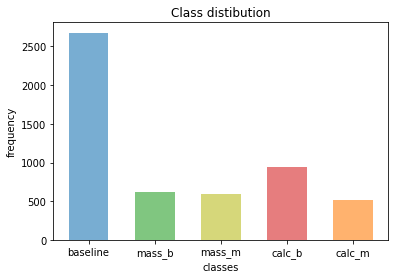

In [9]:
frequency = ut.frequency(labels)
classes = ['baseline', 'mass_b', 'mass_m', 'calc_b', 'calc_m']
colors = ['tab:blue', 'tab:green', 'tab:olive', 'tab:red', 'tab:orange']
plt.bar(classes, frequency, width=0.6, align='center', color=colors, alpha=0.6)
plt.xlabel('classes')
plt.ylabel('frequency')
plt.title('Class distibution')
plt.show()

In [18]:
dataset, lab = ut.binarize(images, labels, 'mass_calcification')

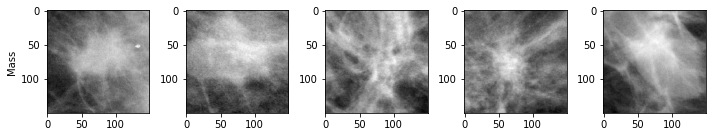

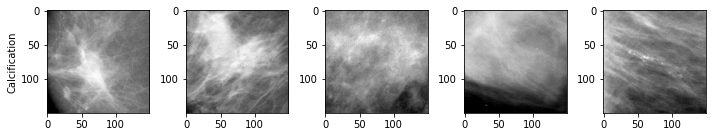

In [19]:
mass_sample = dataset[:5]
calcification_sample = dataset[-5:]
ut.plot_sample(mass_sample, 'Mass')
ut.plot_sample(calcification_sample, 'Calcification')

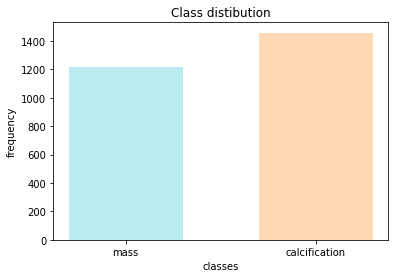

In [20]:
frequency_mc = ut.frequency(lab)
classes_mc = ['mass', 'calcification']
colors_mc = ['tab:cyan', 'tab:orange']
plt.bar(classes_mc, frequency_mc, width=0.6, align='center', color=colors_mc, alpha=0.3)
plt.xlabel('classes')
plt.ylabel('frequency')
plt.title('Class distibution')
plt.show()

In [21]:
mc_weights = class_weight.compute_class_weight('balanced', np.unique(lab), lab)
mc_weights = dict(enumerate(mc_weights))
print('Class weights: ', mc_weights)

Class weights:  {0: 1.0985221674876848, 1: 0.9176954732510288}


In [22]:
dataset, lab = ut.shuffle_dataset(dataset, lab)
dataset = ut.rescale(dataset)
dataset = np.expand_dims(dataset, axis=3)
ut.properties(dataset)

Properties: 
Shape: (2676, 150, 150, 1)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


In [25]:
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_set = data_augmentation.flow(dataset, lab, seed=42, shuffle=True, batch_size=BATCH_SIZE, subset='training')
valid_set = data_augmentation.flow(dataset, lab, batch_size=BATCH_SIZE, subset='validation')

In [24]:
train_size = len(dataset)
valid_size = train_size*0.2
train_size -= valid_size

In [26]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(150,150,1)),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(64, 5, activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(128, 5, activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
], name='mass_calcification')

model.summary()

Model: "mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)      

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        filepath='models/mass_calcification.h5')]

history_mc = model.fit(train_set,
            shuffle=True,
            epochs=100,
            steps_per_epoch=train_size // BATCH_SIZE, 
            batch_size=BATCH_SIZE,
            validation_data=valid_set,
            validation_steps=valid_size // BATCH_SIZE,
            callbacks=callbacks,
            class_weight=mc_weights,
            verbose=1)

Epoch 1/100
66/66 [==============================] - 13s 81ms/step - loss: 0.6996 - accuracy: 0.5125 - val_loss: 0.6923 - val_accuracy: 0.5234
Epoch 2/100
66/66 [==============================] - 5s 76ms/step - loss: 0.6931 - accuracy: 0.5109 - val_loss: 0.6604 - val_accuracy: 0.5605
Epoch 3/100
66/66 [==============================] - 5s 75ms/step - loss: 0.6722 - accuracy: 0.6030 - val_loss: 0.6385 - val_accuracy: 0.6406
Epoch 4/100
66/66 [==============================] - 5s 76ms/step - loss: 0.6178 - accuracy: 0.7133 - val_loss: 0.7131 - val_accuracy: 0.6191
Epoch 5/100
66/66 [==============================] - 5s 78ms/step - loss: 0.5646 - accuracy: 0.7132 - val_loss: 0.5287 - val_accuracy: 0.7207
Epoch 6/100
66/66 [==============================] - 5s 77ms/step - loss: 0.5522 - accuracy: 0.7448 - val_loss: 0.5391 - val_accuracy: 0.7363
Epoch 7/100
66/66 [==============================] - 5s 77ms/step - loss: 0.5367 - accuracy: 0.7296 - val_loss: 0.4906 - val_accuracy: 0.7734
Epoch

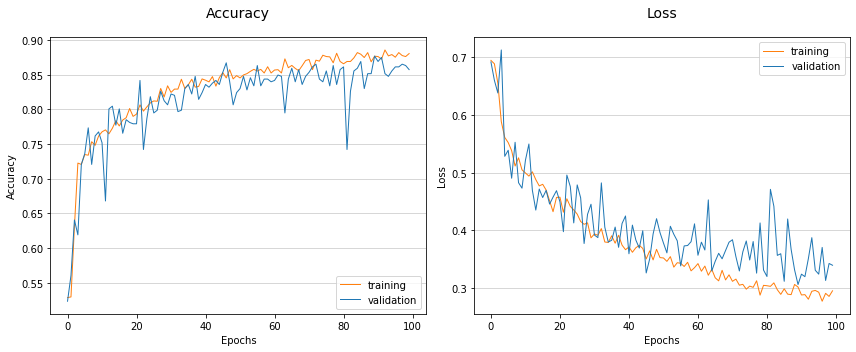

In [31]:
ut.plot_training(history_mc.history['accuracy'], 
                    history_mc.history['loss'], 
                    history_mc.history['val_accuracy'], 
                    history_mc.history['val_loss'], 
                    100,
                    'figures/scratch_mass_calcification.png')

In [32]:
test_dataset, test_lab = ut.binarize(test_images, test_labels, 'mass_calcification')
test_dataset = ut.rescale(test_dataset)
test_dataset = np.expand_dims(test_dataset, axis=3)

In [36]:
predicted = model.predict(test_dataset, verbose=1)
predicted = [0 if x <=0.5 else 1 for x in predicted]
ut.evaluate_classifier(test_lab, predicted)

11/11 [==============================] - 0s 11ms/step
Performances: 
Accuracy:  0.8690476190476191
Precision:  0.834319526627219
Recall:  0.8980891719745223
F1-score:  0.8650306748466259
AUC:  0.8708322954844678


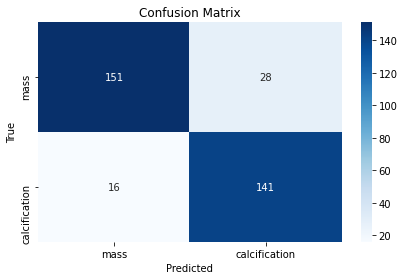

In [37]:
ut.plot_confusion_matrix(test_lab, predicted, ['mass', 'calcification'], 'figures/scratch_mass_calcification_confusion_matrix.png')